This program is modified from https://www.kaggle.com/code/purplejester/a-simple-lstm-based-time-series-classifier/notebook

In [1]:
%matplotlib inline
# !nvidia-smi

In [2]:
from multiprocessing import cpu_count
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, TensorDataset, DataLoader, WeightedRandomSampler
from torch.optim.lr_scheduler import _LRScheduler
import os
import pickle
from random import randint

In [3]:
seed = 1
np.random.seed(seed)
torch.cuda.set_device(0)  # choose the gpu_id you want to use

In [4]:
# some global hyper-parameters
PU_LEARNING = False
len_min = 120 # the fixed seq length (in frame, and the data source is 24fps) of each training samples, the training sample smaller than this length will be filtered away
bs = 64 # batch size
interval = 4 # it means sampling once for every XX data points, so the actual seq length becomes len_min/interval

folder = ["./asd_result/train","./asd_result/test", "./asd_result/val"] # the directories of train, test, and val dataset, NOTE THAT it requires preprocessed data, not raw data
path_prior = folder[0]+"/distribution.csv" # the file that stores training data label (0/1) distribution used for PULearning

# Loading the Data
First of all, we read the files and drop the irrelavant columns.

In [5]:
def get_datapath(folder):
    subfolder = [ f.path for f in os.scandir(folder) if f.is_dir()]
    subsubfolder = []
    for i in subfolder:
        if os.path.isdir(i+'/data'): 
            temp = [ f.path for f in os.scandir(i+'/data') if f.is_file()] # here it is better to exclude hidden file, but I haven't found how
            subsubfolder = subsubfolder + temp
    return subsubfolder

class MyDataset(Dataset):
    def __init__(self, datapath, data_len, interval):
        self.data_files = sorted(datapath)
        self.interval = interval
        self.data_len = data_len # the expected length of each training sample

    def __getitem__(self, idx):
        with open(self.data_files[idx], 'rb') as f:
            x_id, y_id, data = pickle.load(f)
        offset=randint(0,self.interval-1)
        x = data[-self.data_len+offset::self.interval,:]
        y = np.array([1.]) if x_id==y_id else np.array([0.])
        return x, y

    def __len__(self):
        return len(self.data_files)
    
def collate_fn(batch):
    batch = list(filter(lambda x: x is not None, batch))
    return torch.utils.data.dataloader.default_collate(batch)

def filterlength(datapath,data_len,flag):
    filename = "./datapath_filtered/data"+flag+"_"+str(data_len)
    labelfile = "./datapath_filtered/label"+flag+"_"+str(data_len) 
    if os.path.isfile(filename):
        with open(filename, 'rb') as f:
            datapath_filtered = pickle.load(f)
    if os.path.isfile(labelfile):
        with open(labelfile, 'rb') as f:
            label = pickle.load(f)
    if not os.path.isfile(filename) or not os.path.isfile(labelfile):
        datapath_filtered=[]
        label=[]
        for i in datapath:
            with open(i, 'rb') as f:
                x_id, y_id, data = pickle.load(f)
            if len(data) >= data_len:
                datapath_filtered.append(i)
                y = 1 if x_id==y_id else 0
                label.append(y)
        os.makedirs(os.path.dirname("./datapath_filtered/"), exist_ok=True)
        with open(filename, 'wb') as f:
            pickle.dump(datapath_filtered, f)
        with open(labelfile, 'wb') as f:
            pickle.dump(label, f)

    return datapath_filtered, label

In [6]:
print('Preparing datasets')

trn_datapath, trn_label = filterlength(get_datapath(folder[0]),len_min,"train")
val_datapath, val_label = filterlength(get_datapath(folder[2]),len_min,"val")

Preparing datasets


In [7]:
# calculate class prior for PU learning
if PU_LEARNING:
    dist = pd.read_csv(path_prior)
    ind = dist.loc[dist["sample length"] >= len_min].index[0]
    dist = dist.iloc[ind:]
    pos = dist["postive"].sum()
    neg = dist["unlabeled"].sum()
    prior = float(pos/(pos+neg))

In [8]:
def create_sampler(label):
    class_sample_count = np.array([label.count(0), label.count(1)])
    weight = 1./class_sample_count
    samples_weight = np.array([weight[t] for t in label])
    sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
    return sampler

In [9]:
print(f'Creating data loaders with batch size: {bs}')
trn_ds = MyDataset(trn_datapath, data_len=len_min, interval=interval)
val_ds = MyDataset(val_datapath, data_len=len_min, interval=interval)

# balance the class
trn_dl = DataLoader(trn_ds, batch_size=bs, shuffle=False, collate_fn=collate_fn, num_workers=0, sampler=create_sampler(trn_label))
val_dl = DataLoader(val_ds, batch_size=bs, shuffle=False, collate_fn=collate_fn, num_workers=0, sampler=create_sampler(val_label))

Creating data loaders with batch size: 64


# Implementation of PU Loss
source: https://github.com/cimeister/pu-learning/blob/master/loss.py  
example: https://github.com/cimeister/pu-learning/blob/master/run_classifier.py

In [10]:
class PULoss(nn.Module):
    """wrapper of loss function for PU learning"""

    def __init__(self, prior, loss=(lambda x: torch.sigmoid(-x)), gamma=1, beta=0, nnPU=False):
        super(PULoss,self).__init__()
        if not 0 < prior < 1:
            raise NotImplementedError("The class prior should be in (0, 1)")
        self.prior = prior
        self.gamma = gamma
        self.beta = beta
        self.loss_func = loss#lambda x: (torch.tensor(1., device=x.device) - torch.sign(x))/torch.tensor(2, device=x.device)
        self.nnPU = nnPU
        self.positive = 1
        self.unlabeled = 0
        self.min_count = torch.tensor(1.)
    
    def forward(self, inp, target, test=False):
        assert(inp.shape == target.shape)        
        positive, unlabeled = target == self.positive, target == self.unlabeled
        positive, unlabeled = positive.type(torch.float), unlabeled.type(torch.float)
        if inp.is_cuda:
            self.min_count = self.min_count.cuda()
#             self.prior = self.prior.cuda()
        n_positive, n_unlabeled = torch.max(self.min_count, torch.sum(positive)), torch.max(self.min_count, torch.sum(unlabeled))
        
        y_positive = self.loss_func(positive*inp) * positive
        y_positive_inv = self.loss_func(-positive*inp) * positive
        y_unlabeled = self.loss_func(-unlabeled*inp) * unlabeled

        positive_risk = self.prior * torch.sum(y_positive)/ n_positive
        negative_risk = - self.prior *torch.sum(y_positive_inv)/ n_positive + torch.sum(y_unlabeled)/n_unlabeled

        if negative_risk < -self.beta and self.nnPU:
            return -self.gamma * negative_risk
        else:
            return positive_risk+negative_risk

# Cyclic Learning Rate (currently disabled)
The recent papers by L. Smith show us that the cyclic learning rate schedulers have very positive influence on model's convergence speed. In the following cells, we implement a simple cosine scheduler for our model.

In [11]:
class CyclicLR(_LRScheduler):
    
    def __init__(self, optimizer, schedule, last_epoch=-1):
        assert callable(schedule)
        self.schedule = schedule
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        return [self.schedule(self.last_epoch, lr) for lr in self.base_lrs]
    
def cosine(t_max, eta_min=0):
    
    def scheduler(epoch, base_lr):
        t = epoch % t_max
        return eta_min + (base_lr - eta_min)*(1 + np.cos(np.pi*t/t_max))/2
    
    return scheduler

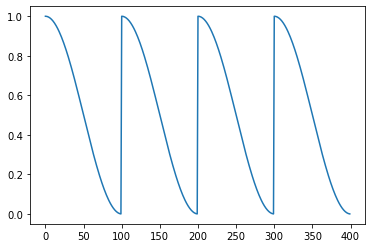

In [12]:
n = 100
sched = cosine(n)
lrs = [sched(t, 1) for t in range(n * 4)]
plt.plot(lrs)

# The LSTM Model
Our classifier contains of several LSTM cells (hidden under the hood of nn.LSTM), and one nn.Linear layer. Note that we use batch_first=True to make sure that the first dimension of our tensors is interpreted as a batch size, and the next one - as a time dimension.

In [13]:
class LSTMClassifier(nn.Module):
    """Very simple implementation of LSTM-based time-series classifier."""
    
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.rnn = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.batch_size = None
        self.hidden = None
    
    def forward(self, x):
        h0, c0 = self.init_hidden(x)
        out, (hn, cn) = self.rnn(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
    
    def init_hidden(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        return [t.cuda() for t in (h0, c0)]

In [14]:
class ConvLSTMClassifier(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.cnn1 = nn.Conv1d(input_dim, 64, kernel_size=5, stride=2, padding=0)
        self.cnn2 = nn.Conv1d(64, 32, kernel_size=5, stride=2, padding=0)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(32)
        self.prelu1 = nn.PReLU()
        self.prelu2 = nn.PReLU()
        self.dropout1 = nn.Dropout(p=0.2)
        self.dropout2 = nn.Dropout(p=0.5)
        self.rnn = nn.LSTM(32, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.batch_size = None
        self.hidden = None
    
    def forward(self, x):
        x = x.permute(0, 2, 1) # swap dimension (1,2) because Conv1d requires (batch, feature, seq), where the LSTM input is (batch, seq, feature)
        x = self.cnn1(x)
        x = self.prelu1(self.bn1(x))
        x = self.dropout1(x)
        x = self.cnn2(x)
        x = self.prelu2(self.bn2(x))
        x = self.dropout2(x)
        x = x.permute(0, 2, 1)
        h0, c0 = self.init_hidden(x)
        out, (hn, cn) = self.rnn(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
    
    def init_hidden(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        return [t.cuda() for t in (h0, c0)]

# Training Loop
Finally, we are ready to bring everything together and train the model.

In [15]:
def my_plot(epochs, loss, loss_val):
    fig = plt.figure()
    ax0 = fig.add_subplot(211, title='train')
    ax1 = fig.add_subplot(212, title='val')
    ax0.plot(epochs, loss, 'bo-')
    ax1.plot(epochs, loss_val, 'ro-')
    ax0.set_xlabel('epoch')
    ax0.set_ylabel('loss')
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('loss')

Start model training
Epoch 1 best model saved with accuracy: 48.96%
Epoch 3 best model saved with accuracy: 64.68%
Epoch:   5. Loss: 0.6036. Acc.: 62.74%
Epoch 6 best model saved with accuracy: 66.55%
Epoch:  10. Loss: 0.5172. Acc.: 56.28%
Epoch:  15. Loss: 0.6066. Acc.: 66.04%
Epoch:  20. Loss: 0.5390. Acc.: 61.09%
Epoch:  25. Loss: 0.5471. Acc.: 65.69%
Epoch:  30. Loss: 0.5960. Acc.: 60.37%
Epoch:  35. Loss: 0.4511. Acc.: 61.31%
Epoch:  40. Loss: 0.4944. Acc.: 57.14%
Epoch:  45. Loss: 0.6153. Acc.: 64.39%
Epoch 49 best model saved with accuracy: 66.76%
Epoch:  50. Loss: 0.4786. Acc.: 60.88%
Epoch:  55. Loss: 0.6601. Acc.: 63.53%
Epoch:  60. Loss: 0.6276. Acc.: 60.52%
Epoch:  65. Loss: 0.6517. Acc.: 58.44%
Epoch:  70. Loss: 0.5944. Acc.: 56.42%
Epoch:  75. Loss: 0.5493. Acc.: 58.36%
Epoch:  80. Loss: 0.5797. Acc.: 64.18%
Epoch:  85. Loss: 0.6587. Acc.: 60.59%
Epoch:  90. Loss: 0.5080. Acc.: 62.17%
Epoch:  95. Loss: 0.5630. Acc.: 61.59%
Epoch: 100. Loss: 0.5931. Acc.: 56.50%
Epoch: 105

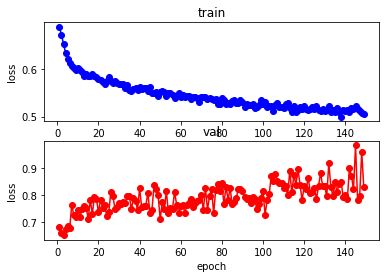

In [16]:
######### LSTM hyper-parameters
input_dim = 196   
hidden_dim = 16
layer_dim = 2
output_dim = 1

lr = 0.0002
n_epochs = 200
iterations_per_epoch = len(trn_dl)
best_acc = 0
patience, trials = 100, 0
#########

epoch_loss=[]
epoch_loss_val=[]

model = ConvLSTMClassifier(input_dim, hidden_dim, layer_dim, output_dim)
model = model.cuda()

if PU_LEARNING:
    criterion = PULoss(prior=prior)
else:
    criterion = nn.BCEWithLogitsLoss() # nn.CrossEntropyLoss() # bug: change to binary entropy loss

opt = torch.optim.RAdam(model.parameters(), lr=lr)
# sched = CyclicLR(opt, cosine(t_max=iterations_per_epoch * 2, eta_min=lr/100))
sched=None

print('Start model training')

for epoch in range(1, n_epochs + 1):
    
    seed = epoch
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    running_loss = 0.0
    
    for i, (x_batch, y_batch) in enumerate(trn_dl):
        model.train()
        x_batch = x_batch.cuda()
        y_batch = y_batch.cuda()
        opt.zero_grad()
        out = model(x_batch)
        loss = criterion(out, y_batch)
        loss.backward()
        opt.step()
#         sched.step()
        
        running_loss += loss.item() * y_batch.shape[0] 
    epoch_loss.append(running_loss / len(trn_ds))
    
    seed = 0
    np.random.seed(seed)
    torch.manual_seed(seed)
        
    model.eval()
    correct, total = 0, 0
    
    running_loss = 0.0
    
    for x_val, y_val in val_dl:
        x_val, y_val = [t.cuda() for t in (x_val, y_val)]
        out = model(x_val)
        preds = out>0.5
        total += y_val.size(0)
        correct += (preds == y_val).sum().item()
        
        loss_val = criterion(out, y_val)
        running_loss += loss_val.item() * y_val.shape[0]
    epoch_loss_val.append(running_loss / len(val_ds))
    
    acc = correct / total

    if epoch % 5 == 0:
        print(f'Epoch: {epoch:3d}. Loss: {loss.item():.4f}. Acc.: {acc:2.2%}')

    if acc > best_acc:
        trials = 0
        best_acc = acc
        torch.save(model.state_dict(), 'best.pth')
        print(f'Epoch {epoch} best model saved with accuracy: {best_acc:2.2%}')
    else:
        trials += 1
        if trials >= patience:
            print(f'Early stopping on epoch {epoch}')
            break
            
my_plot(np.arange(1, epoch+1), epoch_loss, epoch_loss_val)   

In [21]:
torch.onnx.export(model, x_val[:1,:], 'lstm.onnx', verbose=True,
                  input_names=["input"], output_names=["output"],
                  opset_version=11) # output model only accept batch_size=1

graph(%input : Float(1, 30, 196, strides=[5880, 196, 1], requires_grad=0, device=cuda:0),
      %fc.weight : Float(1, 16, strides=[16, 1], requires_grad=1, device=cuda:0),
      %fc.bias : Float(1, strides=[1], requires_grad=1, device=cuda:0),
      %217 : Float(64, 196, 5, strides=[980, 5, 1], requires_grad=0, device=cuda:0),
      %218 : Float(64, strides=[1], requires_grad=0, device=cuda:0),
      %220 : Float(32, 64, 5, strides=[320, 5, 1], requires_grad=0, device=cuda:0),
      %221 : Float(32, strides=[1], requires_grad=0, device=cuda:0),
      %222 : Float(1, 1, strides=[1, 1], requires_grad=0, device=cuda:0),
      %223 : Float(1, 1, strides=[1, 1], requires_grad=0, device=cuda:0),
      %241 : Float(1, 64, 32, strides=[2048, 32, 1], requires_grad=0, device=cuda:0),
      %242 : Float(1, 64, 16, strides=[1024, 16, 1], requires_grad=0, device=cuda:0),
      %243 : Float(1, 128, strides=[128, 1], requires_grad=0, device=cuda:0),
      %244 : Float(1, 1, 16, strides=[16, 16, 1], r